In [1]:
from main import *
from hyperparameter import *
from transferlearning import *

# Preprocessing, Visualization, and Train/Val/Test Split

In [2]:
data_dir ='data' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')
print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: data
Training directory: data/Training
Testing directory: data/Testing


In [3]:
# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [4]:
class_names_train = list(train_data.class_indices.keys())
class_names_test = list(test_data.class_indices.keys())
print(class_names_train)

['glioma', 'meningioma', 'notumor', 'pituitary']


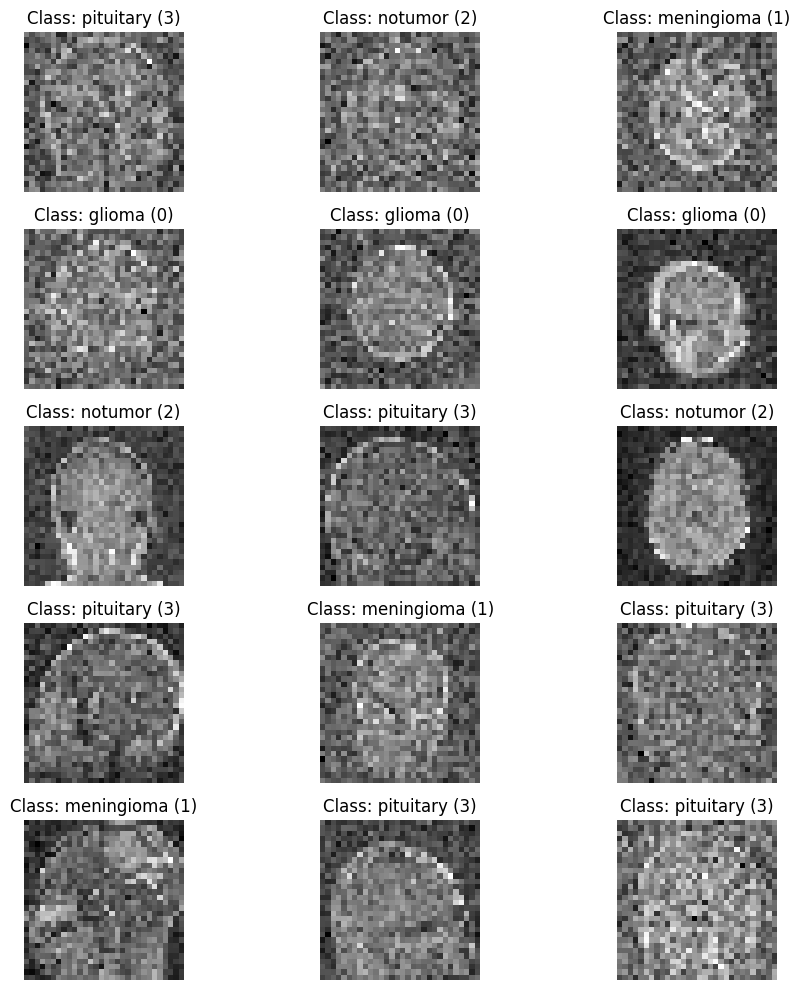

In [5]:
visualize_batch(train_data)

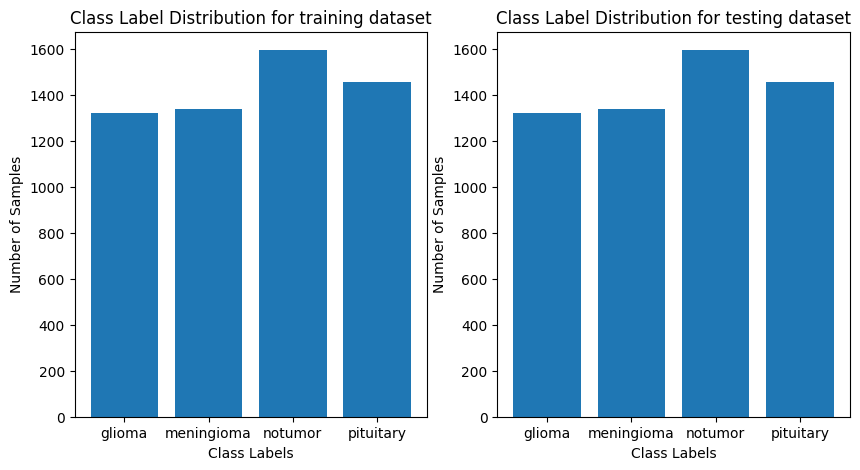

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
plot_class_dist(ax1, train_data, "training")
plot_class_dist(ax2, train_data, "testing")

In [7]:
X_train, y_train, X_val, y_val = train_val_split(train_data)
X_test, y_test = test_splits(test_data)

Number of batches in the training data: 179
Batch size of a single batch 32
Number of samples in the training dataset 5712

Number of training data batches with val split of 0.2: 144
Number of validation data batches: 35

Shape of image training set: (4608, 30, 30, 1)
Shape of image validation set: (1104, 30, 30, 1)

Shape of label training set: (4608, 4)
Shape of label validation set: (1104, 4)
Number of batches in the test data: 41
Batch size of a single batch 32
Number of samples in the test dataset 1311

Shape of image test set: (1311, 30, 30, 1)

Shape of label test set: (1311, 4)


# Baseline Model

In [8]:
base = baseline()
history = base.fit(X_train, y_train, batch_size =32, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - F1Score: 0.4052 - accuracy: 0.4450 - loss: 1.1988 - precision: 0.5981 - recall: 0.1373 - val_F1Score: 0.6898 - val_accuracy: 0.7065 - val_loss: 0.7852 - val_precision: 0.7666 - val_recall: 0.6159
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - F1Score: 0.7027 - accuracy: 0.7143 - loss: 0.7485 - precision: 0.7802 - recall: 0.6177 - val_F1Score: 0.6722 - val_accuracy: 0.6938 - val_loss: 0.7359 - val_precision: 0.7380 - val_recall: 0.6531
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - F1Score: 0.7333 - accuracy: 0.7427 - loss: 0.6730 - precision: 0.7961 - recall: 0.6716 - val_F1Score: 0.7591 - val_accuracy: 0.7690 - val_loss: 0.6180 - val_precision: 0.8178 - val_recall: 0.6993
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - F1Score: 0.7645 - accuracy: 0.7786 - loss: 0.5939 - precision: 0.8161 - recall: 0.7249 - val_F1Score: 0.7745 - val_accuracy: 0.7817 - val_loss: 0.5970 - val_precision: 0.8299 - val_recall: 0.7

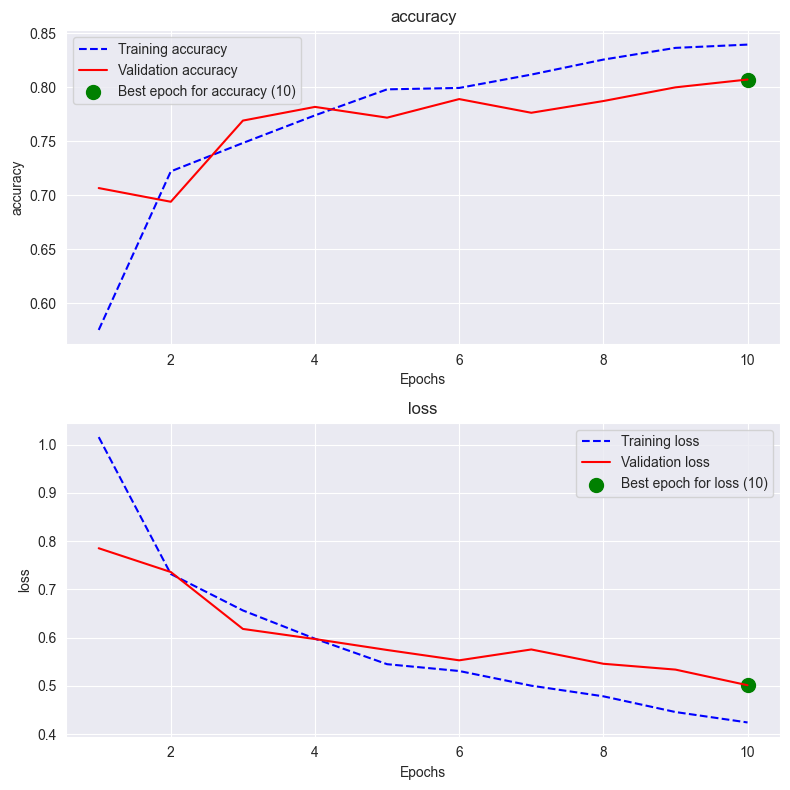

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


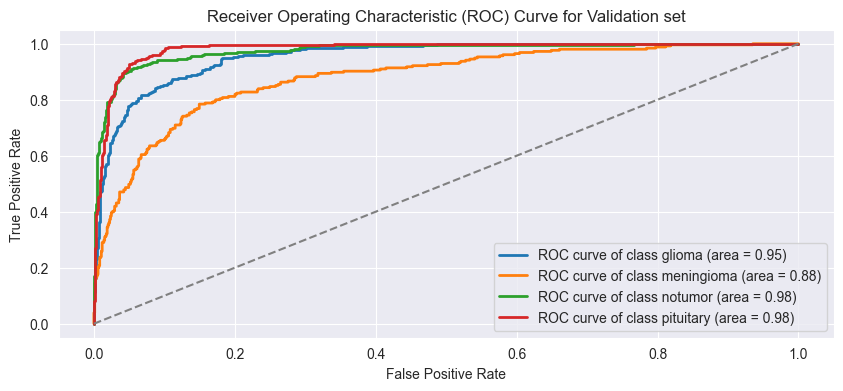

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


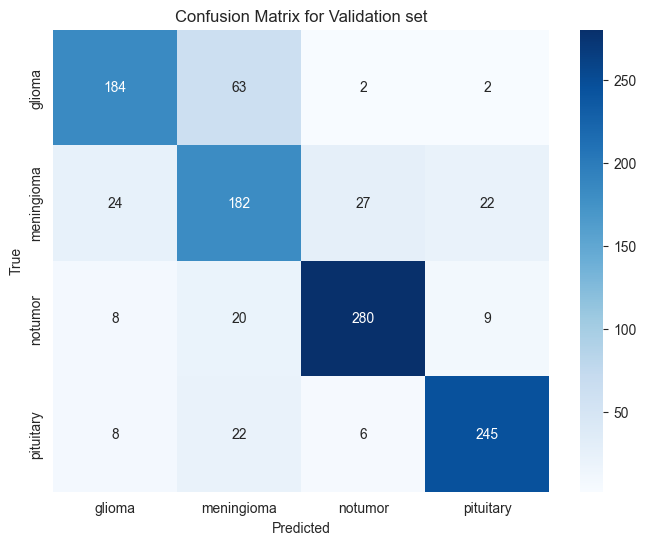

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


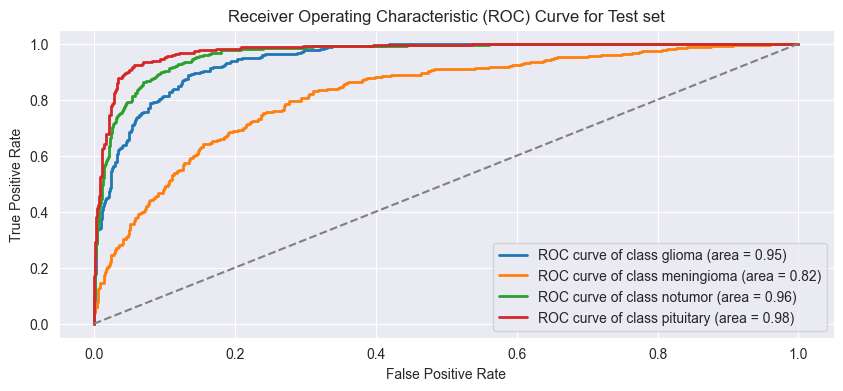

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


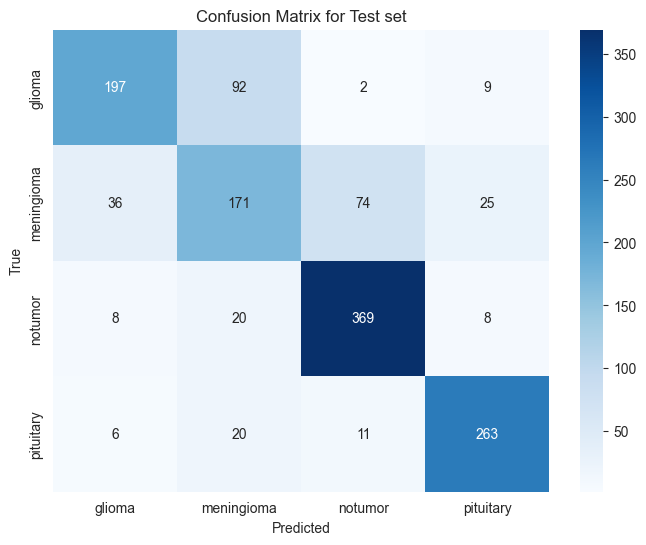

In [9]:
summarize_metric(history)

plot_roc_curve(base, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(base, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')

plot_roc_curve(base, X_test, y_test, class_names_test, title = 'Test set')
plot_confusion_matrix(base, X_test, y_test, class_names_test, normalize=False, title = 'Test set')

In [10]:
models = [base]

metrics, f1 = get_metrics(models, X_test, y_test, class_names_test)
display(metrics.rename(columns = {0: "Baselinemodel"}))
display(f1.rename(columns = {0: "F1"}))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - F1Score: 0.4506 - accuracy: 0.6826 - loss: 0.7278 - precision: 0.6984 - recall: 0.6597


,Baselinemodel
accuracy,0.762776
precision,0.780922
recall,0.736842


,F1
glioma,0.720293
meningioma,0.561576
notumor,0.857143
pituitary,0.869421


# Hyperparamater tuning

In [11]:
hyper = hyperparam()

print(hyper.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 15, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,900 (1.18 MB)

 Trainable params: 308,420 (1.18 MB)

 Non-trainable params: 480 (1.88 KB)

None


In [12]:
early_stopping = callbacks.EarlyStopping(monitor= 'val_loss', patience = 10, start_from_epoch= 20, restore_best_weights= True)
hyper_history = hyper.fit(X_train, y_train, batch_size =4, epochs = 50, validation_data = (X_val, y_val), verbose = 1, callbacks= early_stopping)

Epoch 1/50
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 74s 58ms/step - F1Score: 0.3737 - accuracy: 0.3923 - loss: 1.4479 - precision: 0.4824 - recall: 0.1947 - val_F1Score: 0.6364 - val_accuracy: 0.6676 - val_loss: 0.8196 - val_precision: 0.7947 - val_recall: 0.5154
Epoch 2/50
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 80s 70ms/step - F1Score: 0.5769 - accuracy: 0.6066 - loss: 0.9549 - precision: 0.7252 - recall: 0.4433 - val_F1Score: 0.6039 - val_accuracy: 0.6966 - val_loss: 0.6731 - val_precision: 0.7740 - val_recall: 0.6268
Epoch 3/50
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 87s 75ms/step - F1Score: 0.6371 - accuracy: 0.6701 - loss: 0.7809 - precision: 0.7571 - recall: 0.5552 - val_F1Score: 0.7035 - val_accuracy: 0.7310 - val_loss: 0.6774 - val_precision: 0.8166 - val_recall: 0.6250
Epoch 4/50
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 86s 75ms/step - F1Score: 0.7075 - accuracy: 0.7275 - loss: 0.6684 - precision: 0.7884 - recall: 0.6535 - val_F1Score: 0.7518 - val_accuracy: 0.7708 - val_loss: 0.6316 - val_precision: 0.8164 - val

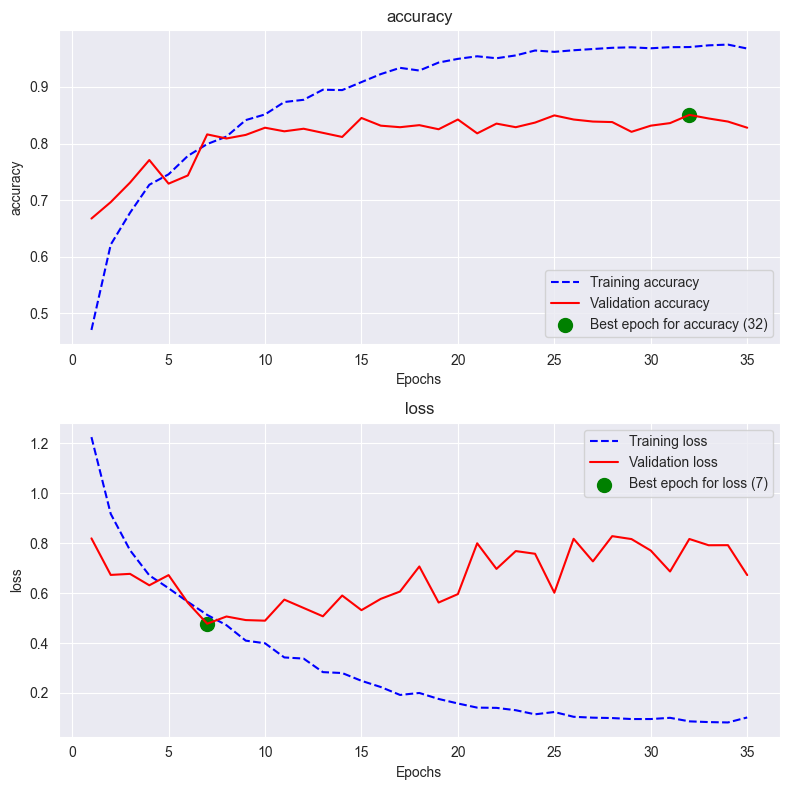

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step


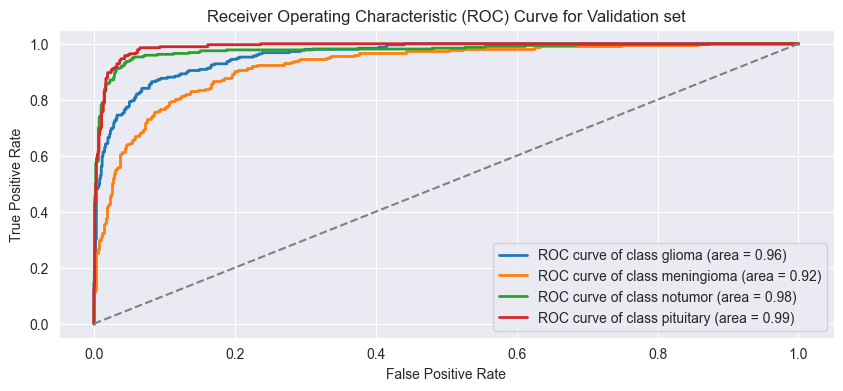

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


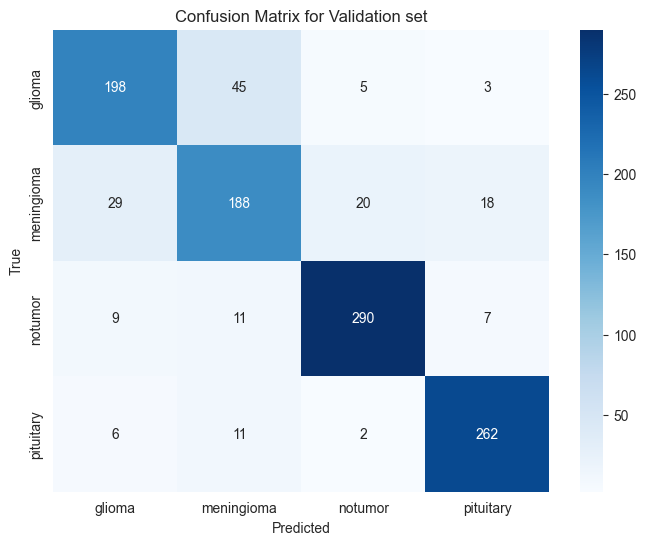

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


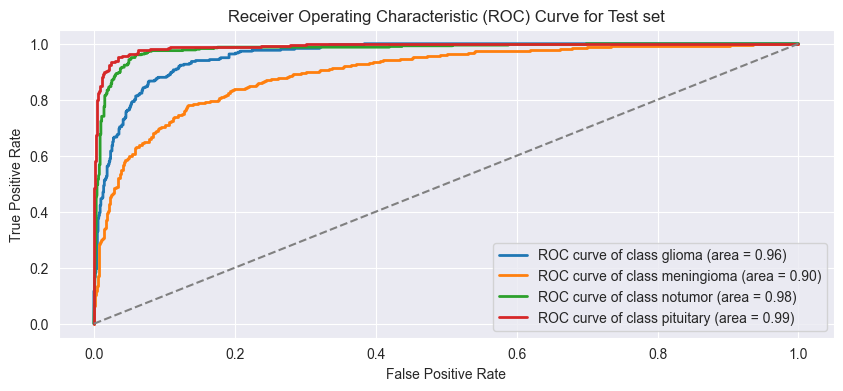

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step


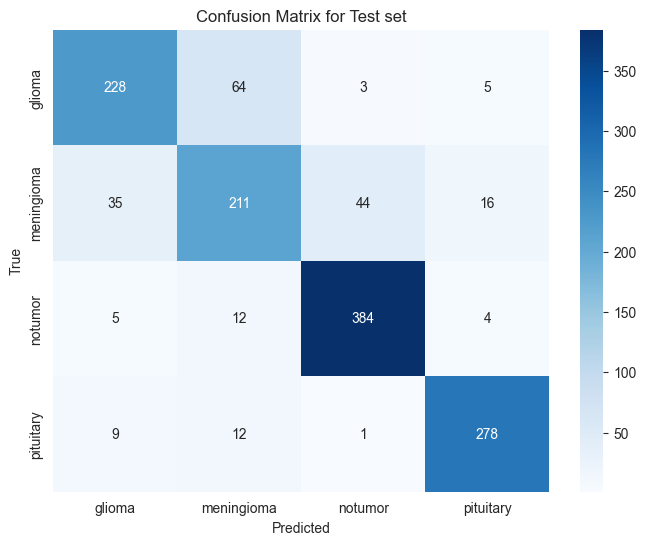

In [13]:
summarize_metric(hyper_history)

plot_roc_curve(hyper, X_val, y_val, class_names_train, title= 'Validation set')
plot_confusion_matrix(hyper, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')

plot_roc_curve(hyper, X_test, y_test, class_names_test, title = 'Test set')
plot_confusion_matrix(hyper, X_test, y_test, class_names_test, normalize=False, title = 'Test set')

# Transfer learning

## VGG16

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 51s 342ms/step - F1Score: 0.4793 - accuracy: 0.4965 - loss: 1.1641 - precision: 0.7458 - recall: 0.1651 - val_F1Score: 0.6105 - val_accuracy: 0.6431 - val_loss: 0.8771 - val_precision: 0.7532 - val_recall: 0.4728
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 49s 341ms/step - F1Score: 0.6376 - accuracy: 0.6523 - loss: 0.8619 - precision: 0.7776 - recall: 0.4781 - val_F1Score: 0.6771 - val_accuracy: 0.6893 - val_loss: 0.7974 - val_precision: 0.7906 - val_recall: 0.5471
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 49s 342ms/step - F1Score: 0.6519 - accuracy: 0.6662 - loss: 0.7972 - precision: 0.7828 - recall: 0.5438 - val_F1Score: 0.6837 - val_accuracy: 0.7002 - val_loss: 0.7810 - val_precision: 0.7911 - val_recall: 0.5489
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 50s 350ms/step - F1Score: 0.6822 - accuracy: 0.6982 - loss: 0.7449 - precision: 0.7922 - recall: 0.5708 - val_F1Score: 0.6463 - val_accuracy: 0.6812 - val_loss: 0.7893 - val_precision: 0.7396 - val_rec

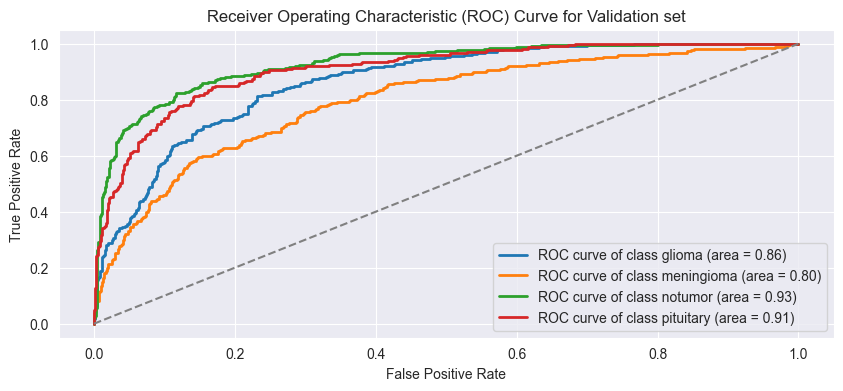

35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step


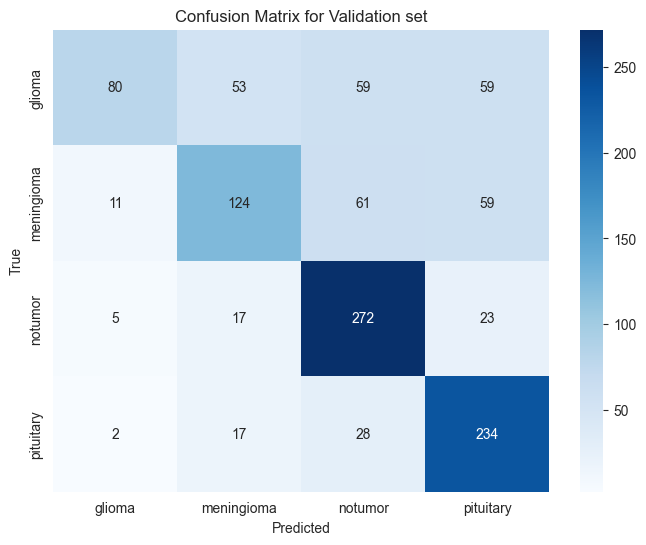

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16

resolution=32

vgg16_model = transfer_learning(VGG16, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam")

plot_roc_curve(vgg16_model, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(vgg16_model, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


## VGG16 with two dense layers

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 54s 347ms/step - F1Score: 0.3764 - accuracy: 0.4035 - loss: 1.2684 - precision: 0.6006 - recall: 0.1165 - val_F1Score: 0.6391 - val_accuracy: 0.6522 - val_loss: 0.9061 - val_precision: 0.7702 - val_recall: 0.4221
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 320ms/step - F1Score: 0.5925 - accuracy: 0.6108 - loss: 0.9263 - precision: 0.7476 - recall: 0.4341 - val_F1Score: 0.6228 - val_accuracy: 0.6495 - val_loss: 0.8595 - val_precision: 0.7669 - val_recall: 0.4946
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 47s 327ms/step - F1Score: 0.6321 - accuracy: 0.6456 - loss: 0.8434 - precision: 0.7509 - recall: 0.4948 - val_F1Score: 0.6822 - val_accuracy: 0.6875 - val_loss: 0.7986 - val_precision: 0.7735 - val_recall: 0.5598
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 47s 330ms/step - F1Score: 0.6478 - accuracy: 0.6570 - loss: 0.8148 - precision: 0.7517 - recall: 0.5278 - val_F1Score: 0.6865 - val_accuracy: 0.6920 - val_loss: 0.7682 - val_precision: 0.7857 - val_rec

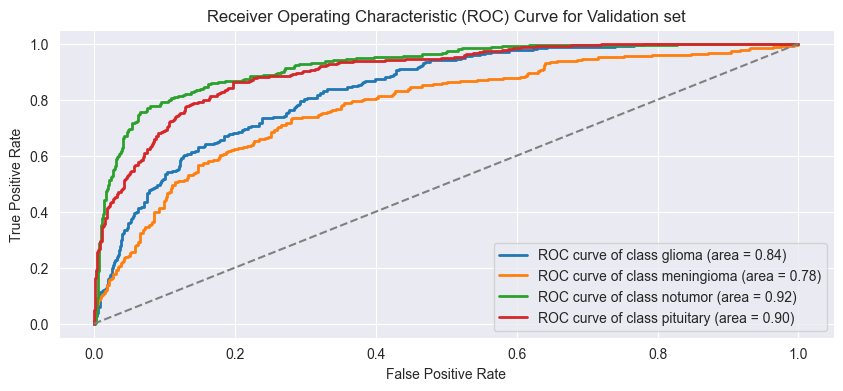

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step


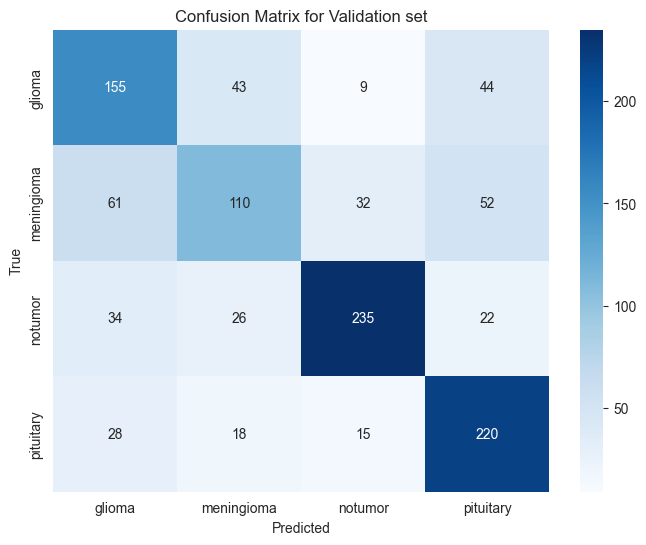

In [15]:

resolution=32

vgg16_model1 = transfer_learning(VGG16, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam", add_extra_layer=True)

plot_roc_curve(vgg16_model1, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(vgg16_model1, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


## Resnet50

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 35s 186ms/step - F1Score: 0.3051 - accuracy: 0.3183 - loss: 1.4777 - precision: 0.4184 - recall: 0.0788 - val_F1Score: 0.5033 - val_accuracy: 0.5063 - val_loss: 1.2065 - val_precision: 0.7803 - val_recall: 0.0933
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - F1Score: 0.4597 - accuracy: 0.4757 - loss: 1.1783 - precision: 0.6955 - recall: 0.1797 - val_F1Score: 0.5007 - val_accuracy: 0.5380 - val_loss: 1.1166 - val_precision: 0.6959 - val_recall: 0.2591
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 202ms/step - F1Score: 0.4936 - accuracy: 0.5092 - loss: 1.1237 - precision: 0.6615 - recall: 0.2416 - val_F1Score: 0.4895 - val_accuracy: 0.5208 - val_loss: 1.1329 - val_precision: 0.6626 - val_recall: 0.3451
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 170ms/step - F1Score: 0.5096 - accuracy: 0.5288 - loss: 1.0879 - precision: 0.6853 - recall: 0.3053 - val_F1Score: 0.5541 - val_accuracy: 0.5634 - val_loss: 1.0486 - val_precision: 0.7245 - val_rec

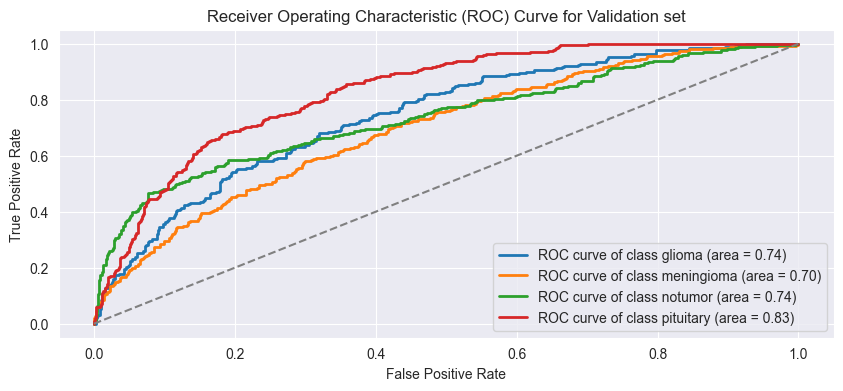

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step


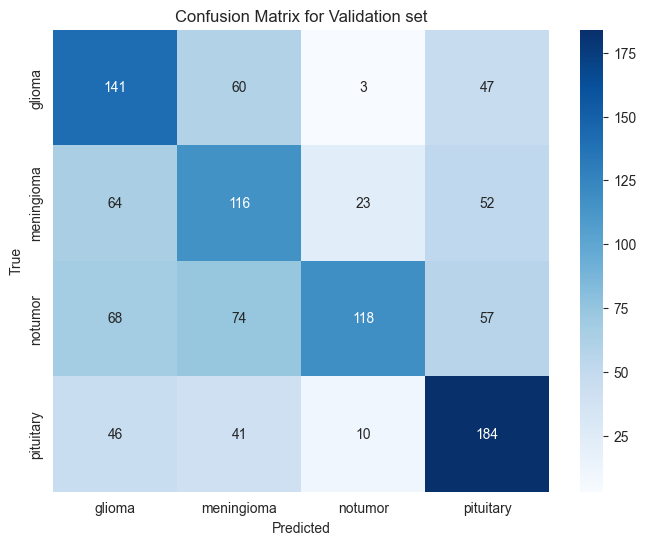

In [16]:
from tensorflow.keras.applications import ResNet50

resolution=32

resnet_model = transfer_learning(ResNet50, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam")

plot_roc_curve(resnet_model, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(resnet_model, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


## Resnet50 with two dense layers

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 35s 180ms/step - F1Score: 0.2727 - accuracy: 0.2889 - loss: 1.4967 - precision: 0.2982 - recall: 0.0402 - val_F1Score: 0.2519 - val_accuracy: 0.3804 - val_loss: 1.2785 - val_precision: 0.7614 - val_recall: 0.0607
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - F1Score: 0.3647 - accuracy: 0.3920 - loss: 1.2748 - precision: 0.6998 - recall: 0.0816 - val_F1Score: 0.3253 - val_accuracy: 0.4067 - val_loss: 1.2516 - val_precision: 0.8046 - val_recall: 0.0634
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - F1Score: 0.3883 - accuracy: 0.4300 - loss: 1.2247 - precision: 0.7230 - recall: 0.1227 - val_F1Score: 0.4857 - val_accuracy: 0.5072 - val_loss: 1.2196 - val_precision: 0.8315 - val_recall: 0.0670
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - F1Score: 0.4125 - accuracy: 0.4257 - loss: 1.2222 - precision: 0.7276 - recall: 0.1151 - val_F1Score: 0.4731 - val_accuracy: 0.4846 - val_loss: 1.2034 - val_precision: 0.8641 - val_rec

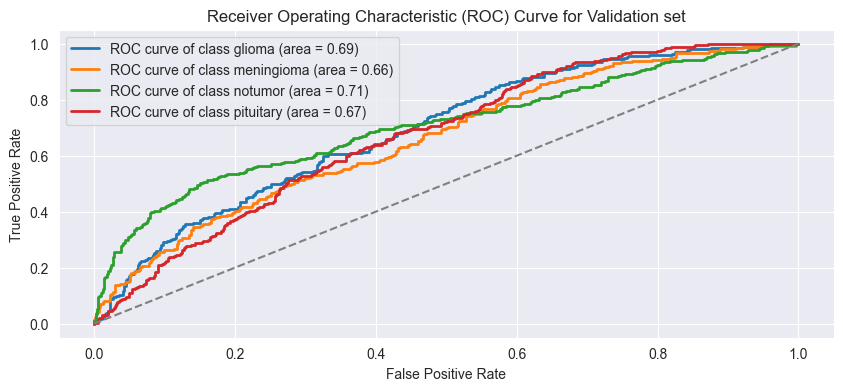

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step


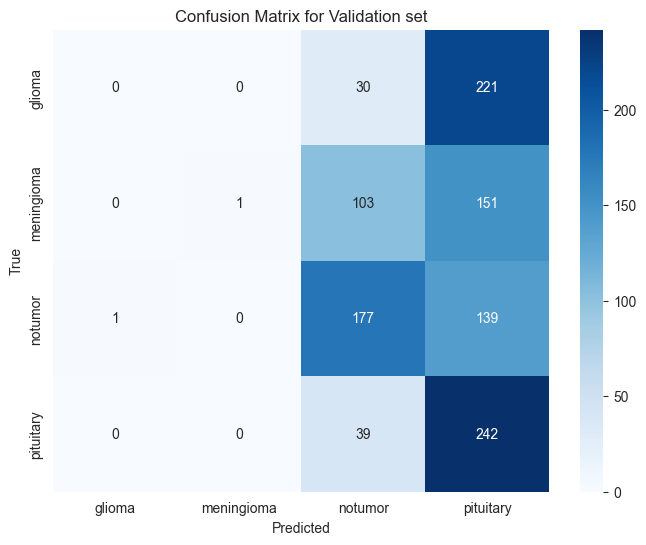

In [17]:
resolution=32

resnet_model1 = transfer_learning(ResNet50, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam", add_extra_layer=True)

plot_roc_curve(resnet_model1, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(resnet_model1, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


## Densenet121

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 48s 231ms/step - F1Score: 0.5090 - accuracy: 0.5202 - loss: 1.1785 - precision: 0.6043 - recall: 0.3585 - val_F1Score: 0.6415 - val_accuracy: 0.6585 - val_loss: 0.8328 - val_precision: 0.7396 - val_recall: 0.5453
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 200ms/step - F1Score: 0.6785 - accuracy: 0.6875 - loss: 0.7604 - precision: 0.7778 - recall: 0.5747 - val_F1Score: 0.6805 - val_accuracy: 0.6902 - val_loss: 0.7518 - val_precision: 0.7753 - val_recall: 0.6033
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - F1Score: 0.7202 - accuracy: 0.7325 - loss: 0.6607 - precision: 0.8166 - recall: 0.6531 - val_F1Score: 0.6884 - val_accuracy: 0.6938 - val_loss: 0.7448 - val_precision: 0.7638 - val_recall: 0.6268
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - F1Score: 0.7369 - accuracy: 0.7470 - loss: 0.6209 - precision: 0.8108 - recall: 0.6717 - val_F1Score: 0.6911 - val_accuracy: 0.6984 - val_loss: 0.7531 - val_precision: 0.7495 - val_rec

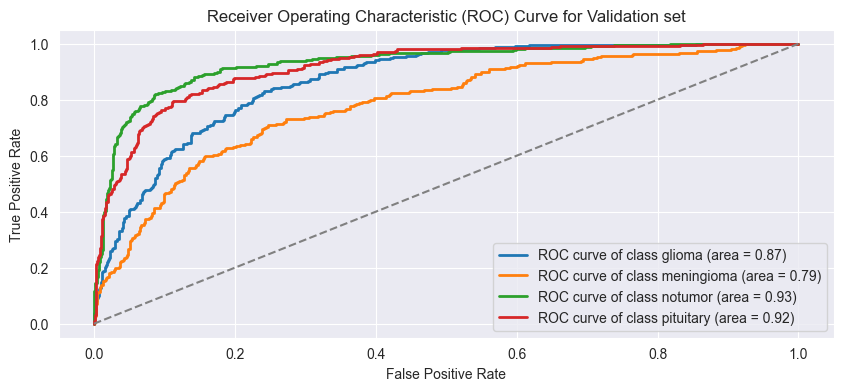

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step


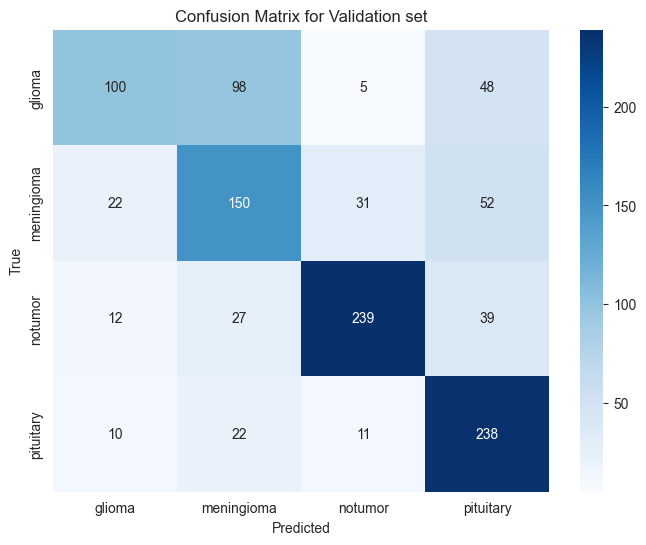

In [18]:
from tensorflow.keras.applications import DenseNet121

resolution=32

densenet_model = transfer_learning(DenseNet121, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam")

plot_roc_curve(densenet_model, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(densenet_model, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


## Densenet121 with two dense layers

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 204ms/step - F1Score: 0.4382 - accuracy: 0.4558 - loss: 1.2139 - precision: 0.5925 - recall: 0.2394 - val_F1Score: 0.6321 - val_accuracy: 0.6522 - val_loss: 0.8383 - val_precision: 0.7903 - val_recall: 0.4710
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - F1Score: 0.6100 - accuracy: 0.6270 - loss: 0.8662 - precision: 0.7226 - recall: 0.4946 - val_F1Score: 0.6715 - val_accuracy: 0.6893 - val_loss: 0.7896 - val_precision: 0.7574 - val_recall: 0.5543
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - F1Score: 0.6596 - accuracy: 0.6735 - loss: 0.7855 - precision: 0.7553 - recall: 0.5611 - val_F1Score: 0.6973 - val_accuracy: 0.7083 - val_loss: 0.7579 - val_precision: 0.7852 - val_recall: 0.5661
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - F1Score: 0.6853 - accuracy: 0.6971 - loss: 0.7379 - precision: 0.7762 - recall: 0.5941 - val_F1Score: 0.6831 - val_accuracy: 0.6984 - val_loss: 0.7448 - val_precision: 0.7731 - val_reca

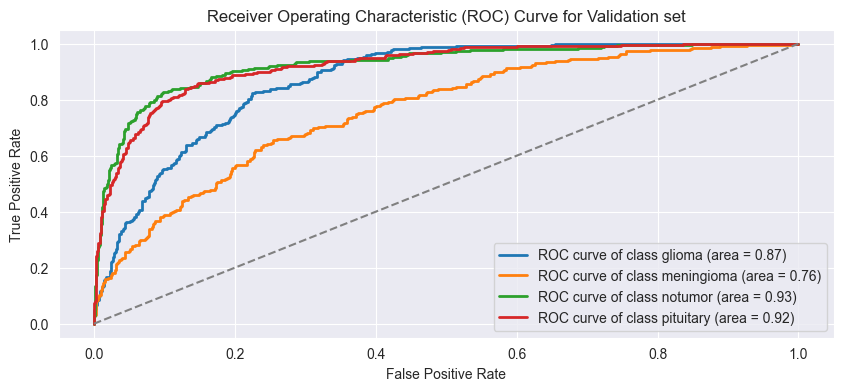

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


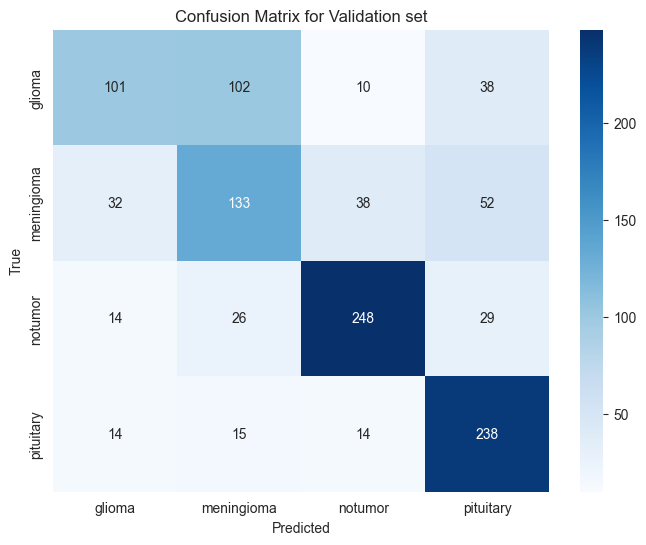

In [19]:
resolution=32

densenet_model1 = transfer_learning(DenseNet121, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam", add_extra_layer=True)

plot_roc_curve(densenet_model1, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(densenet_model1, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


## EfficientNet

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - F1Score: 0.2385 - accuracy: 0.2611 - loss: 1.4293 - precision: 0.3103 - recall: 0.0098 - val_F1Score: 0.1115 - val_accuracy: 0.2871 - val_loss: 1.3842 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - F1Score: 0.2369 - accuracy: 0.2617 - loss: 1.3936 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_F1Score: 0.1115 - val_accuracy: 0.2871 - val_loss: 1.3823 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - F1Score: 0.1858 - accuracy: 0.2716 - loss: 1.3881 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_F1Score: 0.0938 - val_accuracy: 0.2310 - val_loss: 1.3853 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - F1Score: 0.1614 - accuracy: 0.2679 - loss: 1.3867 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_F1Score: 0.1115 - val_accuracy: 0.2871 - val_loss:

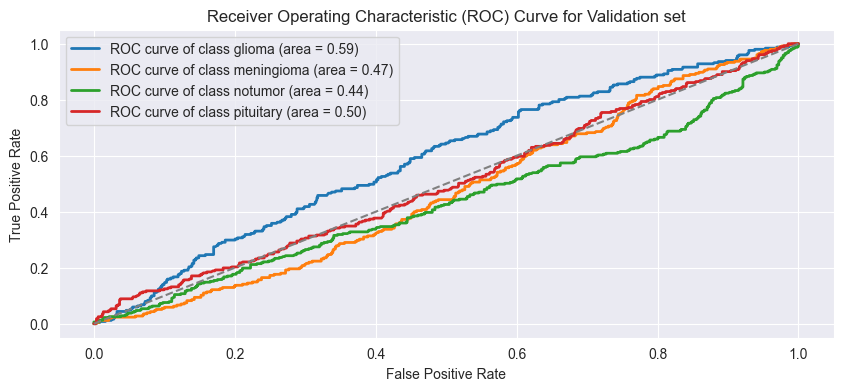

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


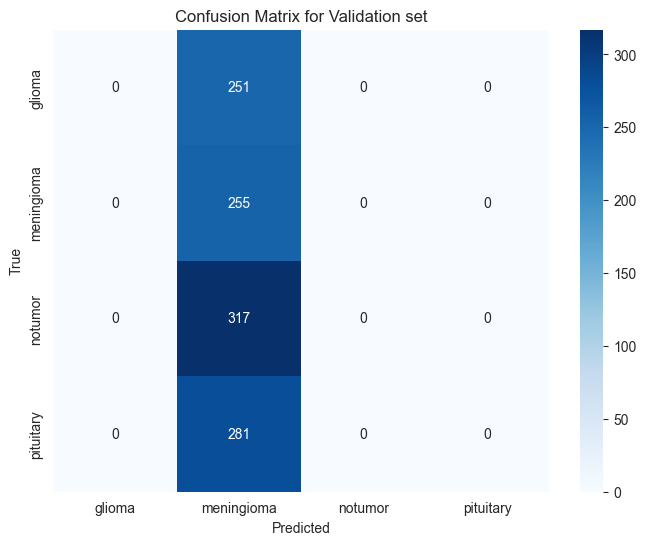

In [20]:
from tensorflow.keras.applications import EfficientNetB0

resolution=32

efficientnet_model = transfer_learning(EfficientNetB0, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam")

plot_roc_curve(efficientnet_model, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(efficientnet_model, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


## EfficientNet80B with 2 dense layers

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - F1Score: 0.2430 - accuracy: 0.2562 - loss: 1.4144 - precision: 0.1752 - recall: 4.3313e-04 - val_F1Score: 0.1115 - val_accuracy: 0.2871 - val_loss: 1.3822 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - F1Score: 0.1869 - accuracy: 0.2733 - loss: 1.3871 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_F1Score: 0.1115 - val_accuracy: 0.2871 - val_loss: 1.3823 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - F1Score: 0.1105 - accuracy: 0.2836 - loss: 1.3828 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_F1Score: 0.1115 - val_accuracy: 0.2871 - val_loss: 1.3822 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - F1Score: 0.1348 - accuracy: 0.2673 - loss: 1.3840 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_F1Score: 0.1115 - val_accuracy: 0.2871 - val_l

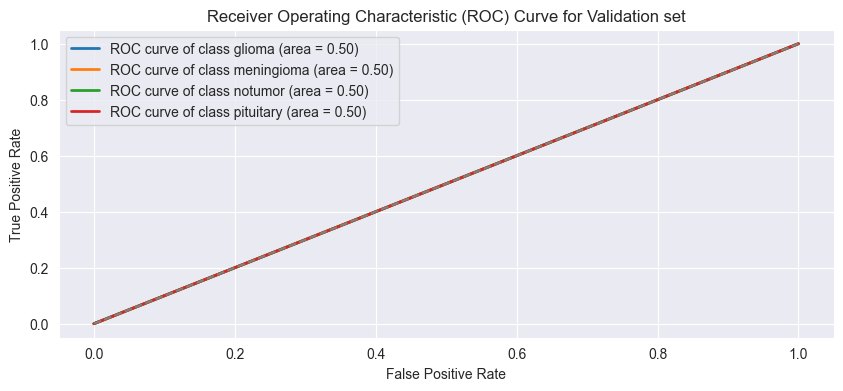

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


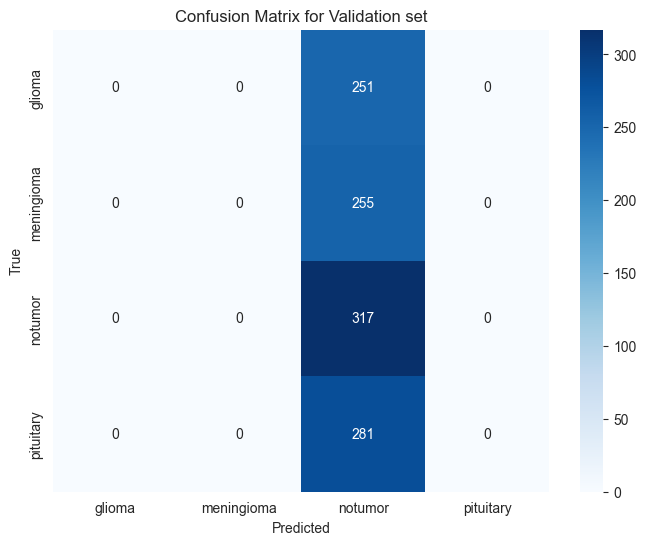

In [21]:
resolution=32

efficientnet_model1 = transfer_learning(EfficientNetB0, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam", add_extra_layer=True)

plot_roc_curve(efficientnet_model1, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(efficientnet_model1, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


## Transfer learning results (without any finetuning)

In [22]:
models = [vgg16_model, resnet_model, densenet_model, efficientnet_model, vgg16_model1, resnet_model1, densenet_model1, efficientnet_model1]

metrics, f1 = get_metrics(models, X_val, y_val, class_names_train)
display(metrics.rename(columns = {0: "VGG16", 1: "Resnet50", 2: "Densenet121", 3: "EfficientNetB0", 4: "VGG16 (2 layers)", 5: "Resnet50 (2 layers)", 6: "Densenet121 (2 layers)", 7: "EfficientNetB0 (2 layers)"}))
display(f1.rename(columns =  {0: "VGG16", 1: "Resnet50", 2: "Densenet121", 3: "EfficientNetB0", 4: "VGG16 (2 layers)", 5: "Resnet50 (2 layers)", 6: "Densenet121 (2 layers)", 7: "EfficientNetB0 (2 layers)"}))

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - F1Score: 0.6207 - accuracy: 0.6568 - loss: 0.8798 - precision: 0.7510 - recall: 0.4781
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - F1Score: 0.4927 - accuracy: 0.4988 - loss: 1.2123 - precision: 0.7761 - recall: 0.0937
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - F1Score: 0.6402 - accuracy: 0.6567 - loss: 0.8357 - precision: 0.7297 - recall: 0.5506
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - F1Score: 0.0986 - accuracy: 0.2458 - loss: 1.3837 - precision: 0.0000e+00 - recall: 0.0000e+00
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - F1Score: 0.6455 - accuracy: 0.6585 - loss: 0.9162 - precision: 0.7821 - recall: 0.4122
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - F1Score: 0.2477 - accuracy: 0.3785 - loss: 1.2837 - precision: 0.7172 - recall: 0.0618
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - F1Score: 0.6286 - accuracy: 0.6492 - loss: 0.8398 - precision: 0.7753 - recall: 0.4622
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - F1Score: 0.1095 - accuracy: 0.2808 - loss: 1.

,VGG16,Resnet50,Densenet121,EfficientNetB0,VGG16 (2 layers),Resnet50 (2 layers),Densenet121 (2 layers),EfficientNetB0 (2 layers)
accuracy,0.643116,0.506341,0.658514,0.230978,0.652174,0.380435,0.652174,0.287138
precision,0.753247,0.780303,0.739558,0.000000,0.770248,0.761364,0.790274,0.000000
recall,0.472826,0.093297,0.545290,0.000000,0.422101,0.060688,0.471014,0.000000


,VGG16,Resnet50,Densenet121,EfficientNetB0,VGG16 (2 layers),Resnet50 (2 layers),Densenet121 (2 layers),EfficientNetB0 (2 layers)
glioma,0.458453,0.494737,0.506329,0.000000,0.586011,0.000000,0.490291,0.000000
meningioma,0.532189,0.424908,0.543478,0.375276,0.486726,0.007812,0.500942,0.000000
notumor,0.738128,0.501061,0.792703,0.000000,0.773026,0.531532,0.791069,0.446165
pituitary,0.713415,0.592593,0.723404,0.000000,0.710824,0.468085,0.746081,0.000000


# Custom model with VGG16 initial weights and convolution blocks
During transfer learning we noticed that the shallow networks work best and we can further improve accuracy by adding a few convolution blocks at the end of the first few layers of VGG16, this helps in capturing the general features from pretrained model and train the model to our special domain

In [29]:
from vgg16_model_custom import custom_vgg16
custom_model = custom_vgg16()
early_stopping = callbacks.EarlyStopping(monitor= 'val_loss', patience = 4, start_from_epoch= 8, restore_best_weights= True)
custom_history = custom_model.fit(X_train, y_train, epochs = 30, validation_data = (X_val, y_val), verbose = 1, callbacks= early_stopping)

Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,735,488 (6.62 MB)

 Trainable params: 1,735,488 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_20 (Lambda)              │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_21 (Lambda)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_82 (Functional)      │ (None, 4, 4, 256)      │     1,735,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 32)       │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,822,708 (6.95 MB)

 Trainable params: 1,822,708 (6.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 48s 322ms/step - F1Score: 0.2774 - accuracy: 0.3164 - loss: 2.8082 - precision: 0.3375 - recall: 0.0731 - val_F1Score: 0.4515 - val_accuracy: 0.5281 - val_loss: 1.1366 - val_precision: 0.6627 - val_recall: 0.3043
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 319ms/step - F1Score: 0.5927 - accuracy: 0.6175 - loss: 0.9347 - precision: 0.7389 - recall: 0.4719 - val_F1Score: 0.6673 - val_accuracy: 0.7165 - val_loss: 0.7966 - val_precision: 0.7505 - val_recall: 0.6784
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 47s 323ms/step - F1Score: 0.6930 - accuracy: 0.7084 - loss: 0.7456 - precision: 0.7673 - recall: 0.6281 - val_F1Score: 0.7178 - val_accuracy: 0.7337 - val_loss: 0.6596 - val_precision: 0.7931 - val_recall: 0.6703
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 47s 328ms/step - F1Score: 0.7485 - accuracy: 0.7573 - loss: 0.6294 - precision: 0.8082 - recall: 0.7098 - val_F1Score: 0.7247 - val_accuracy: 0.7491 - val_loss: 0.6421 - val_precision: 0.7732 - val_rec

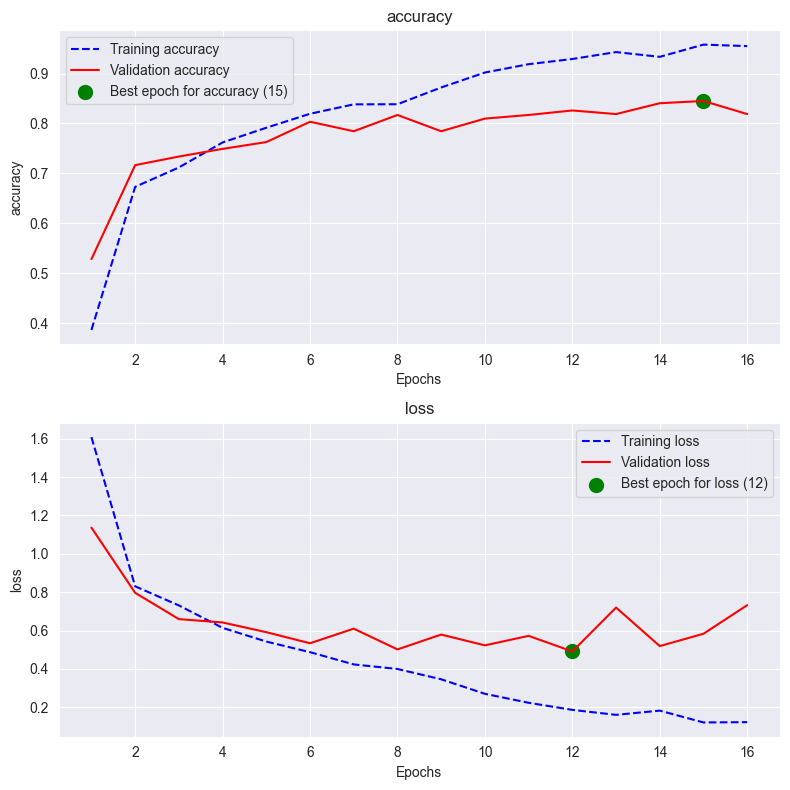

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step


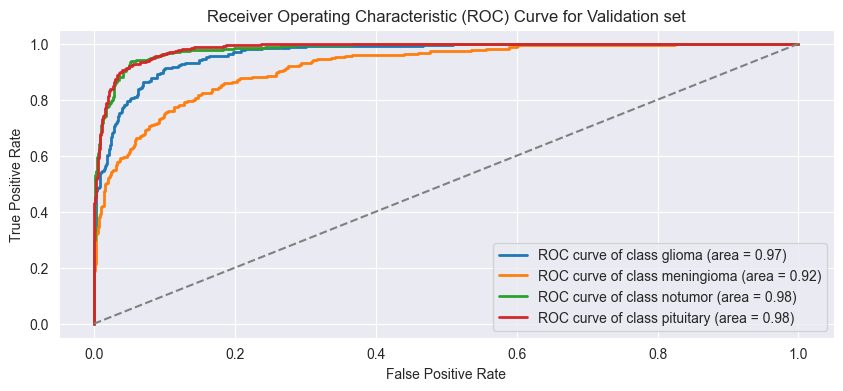

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step


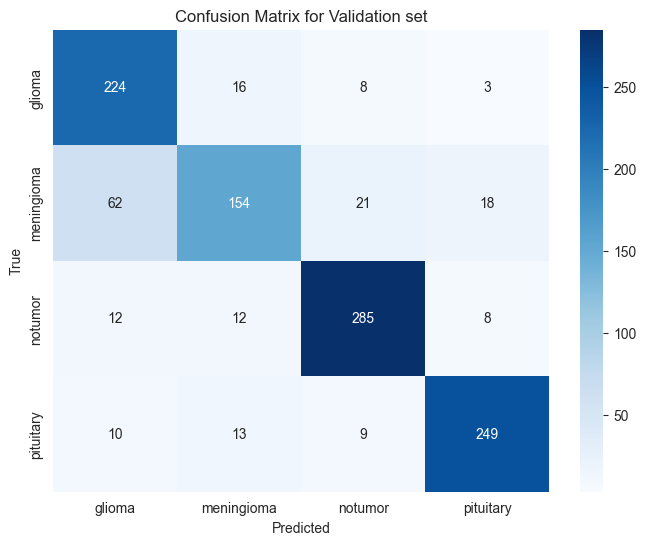

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step


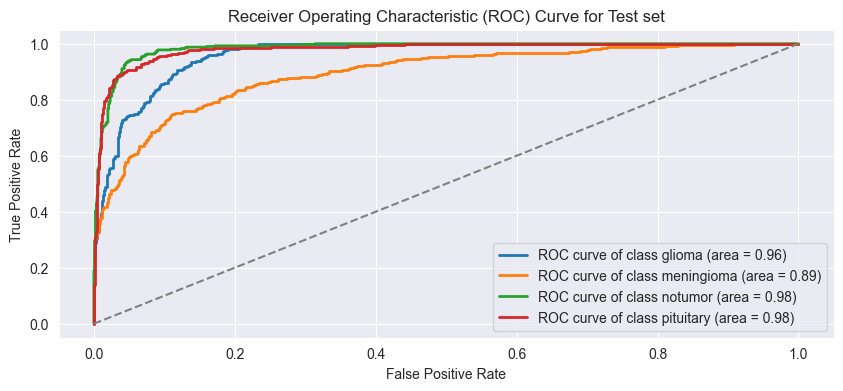

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step


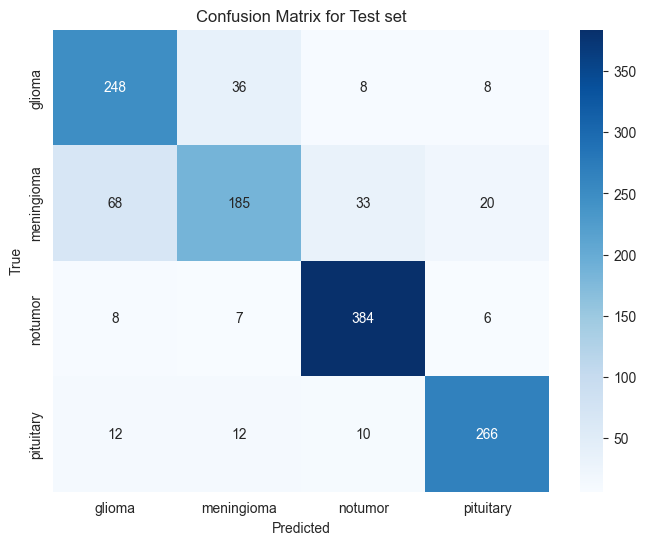

In [30]:
summarize_metric(custom_history)

plot_roc_curve(custom_model, X_val, y_val, class_names_train, title= 'Validation set')
plot_confusion_matrix(custom_model, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')

plot_roc_curve(custom_model, X_test, y_test, class_names_test, title = 'Test set')
plot_confusion_matrix(custom_model, X_test, y_test, class_names_test, normalize=False, title = 'Test set')

In [32]:
models = [custom_model]

metrics, f1 = get_metrics(models, X_test, y_test, class_names_test)
display(metrics.rename(columns = {0: "Custom VGG16 model"}))
display(f1.rename(columns = {0: "F1"}))

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - F1Score: 0.5144 - accuracy: 0.7986 - loss: 0.5818 - precision: 0.8069 - recall: 0.7909


,Custom VGG16 model
accuracy,0.826087
precision,0.833463
recall,0.816934


,F1
glioma,0.779874
meningioma,0.677656
notumor,0.914286
pituitary,0.886667


In [34]:
hyper.save('models/best_hyperparam_model.keras')
vgg16_model.save('models/vgg16_model.keras') 
resnet_model.save('models/resnet_model.keras')
densenet_model.save('models/densenet_model.keras') 
efficientnet_model.save('models/efficientnet_model.keras') 
vgg16_model1.save('models/vgg16_model_2_layers.keras')
resnet_model1.save('models/resnet_model_2_layers.keras')
densenet_model1.save('models/densenet_model_2_layers.keras') 
efficientnet_model1.save('models/efficientnet_model_2_layers.keras')
custom_model.save('models/custom_vgg16.keras')